# Trees and Forests Demo

2022-06-29

Modified version of original notebook by [Zain Hasan](https://drive.google.com/drive/folders/1kzt_ym7MRM4DSxL6ZWlujNzhxWaciFZp?usp=sharing).

In [33]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings('ignore')

## Decision Trees

In [34]:
#function for plotting a decision tree
#input is feature data, class predictions, and the trained model.
def plot_tree(X, y, model, predict_proba = False):
    # Join data for plotting
    sample = (X.join(y))
    # Create a mesh for plotting
    step = (X.max() - X.min()) / 50
    x1, x2 = np.meshgrid(np.arange(sample.min()[0]-step[0], sample.max()[0]+step[0], step[0]),
                         np.arange(sample.min()[1]-step[1], sample.max()[1]+step[1], step[1]))

    # Store mesh in dataframe
    mesh_df = pd.DataFrame(np.c_[x1.ravel(), x2.ravel()], columns=['x1', 'x2'])

    # Mesh predictions
    if predict_proba:
        mesh_df['predictions'] = model.predict_proba(mesh_df[['x1', 'x2']])[:, 0]
        # Plot
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='P(blue)', scale=alt.Scale(scheme='redblue'))
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )
    else:
        mesh_df['predictions'] = model.predict(mesh_df[['x1', 'x2']])
        # Plot
        scat_plot = alt.Chart(sample).mark_circle(
            stroke='black',
            opacity=0.5,
            strokeWidth=1.5,
            size=100
        ).encode(
            x=alt.X(X.columns[0], axis=alt.Axis(labels=True, ticks=True, title=X.columns[0])),
            y=alt.Y(X.columns[1], axis=alt.Axis(labels=True, ticks=True, title=X.columns[1])),
            color=alt.Color(y.columns[0])
        )
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='Legend')
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot, scat_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )

### Let's see how decision trees work
1. Load our data
1. Training / testing split
1. Fit a **classification tree**

In [35]:
#load data
df = pd.read_csv('data/cities_USA.csv', index_col=0)
df.head()

,lon,lat,vote
1,-80.162475,25.692104,blue
2,-80.214360,25.944083,blue
3,-80.094133,26.234314,blue
4,-80.248086,26.291902,blue
5,-81.789963,26.348035,blue


In [36]:
df['vote'].value_counts()

blue    234
red     166
Name: vote, dtype: int64

In [37]:
#split data into training and testing sets
X = df.drop(columns=['vote'])
y = df[['vote']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

In [38]:
#train a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3, random_state=16)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=16)

### What did the classification tree do?
- Found a good way to split and repeat

In [39]:
plot_tree(X_train, y_train, model)

alt.LayerChart(...)

In [40]:
from sklearn.tree import export_text

tree_rules = export_text(model, feature_names=list(X_train.columns))
print(tree_rules)

|--- lon <= -80.28
|   |--- lat <= 37.68
|   |   |--- lon <= -114.06
|   |   |   |--- class: blue
|   |   |--- lon >  -114.06
|   |   |   |--- class: red
|   |--- lat >  37.68
|   |   |--- lon <= -96.01
|   |   |   |--- class: red
|   |   |--- lon >  -96.01
|   |   |   |--- class: blue
|--- lon >  -80.28
|   |--- lat <= 36.51
|   |   |--- lon <= -79.05
|   |   |   |--- class: blue
|   |   |--- lon >  -79.05
|   |   |   |--- class: red
|   |--- lat >  36.51
|   |   |--- lon <= -78.63
|   |   |   |--- class: blue
|   |   |--- lon >  -78.63
|   |   |   |--- class: blue



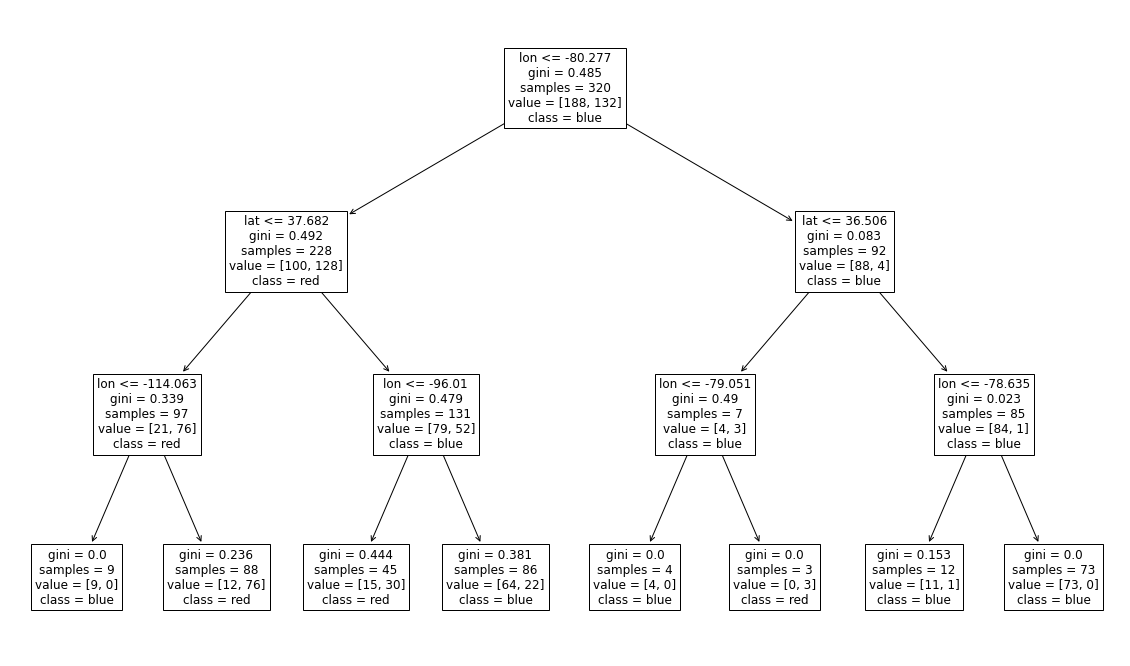

In [41]:
#view the tree to a depth of 3
from sklearn import tree

plt.figure(figsize=(20, 12))
tree.plot_tree(model, max_depth=3, 
               feature_names=X.columns,
               class_names=["blue", "red"],
               fontsize=12)

plt.show()

### Regression trees

In [67]:
np.random.seed(333)

#create dummy data
df = pd.DataFrame({'feature_1': np.random.randint(0, 10, (10,)),
                   'feature_2': np.random.randint(0, 10, (10,)),
                   'target': np.random.randint(0, 10, (10,))})
df

,feature_1,feature_2,target
0,3,7,3
1,3,5,3
2,6,5,7
3,3,8,7
4,7,8,1
5,7,7,0
6,6,3,8
7,4,3,2
8,4,3,7
9,9,9,0


In [68]:
X = df.drop(columns='target')
y = df['target']

#train decision tree regressor
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=3).fit(X, y)

### Visualizing the first decision

In [69]:
#visualize the first decision
scatter = alt.Chart(df).mark_circle(
    size=150,
    opacity=1,
    stroke='black',
    strokeWidth=1
).encode(
    x=alt.X('feature_1', title='feature_1'),
    y=alt.Y('feature_2', title='feature_2'),
    color='target')
text = scatter.mark_text(
    align='left',
    baseline='middle',
    fontSize = 20,
    dx=8
).encode(
    text='target')
split = alt.Chart(df).mark_rule().encode(
    x='a:Q',
    size=alt.SizeValue(2),
    color=alt.ColorValue("red")
).transform_calculate(
    a="6.5"
)
alt.layer(scatter, text, split).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize=20
).properties(
    width=300,
    height=300
)

alt.LayerChart(...)

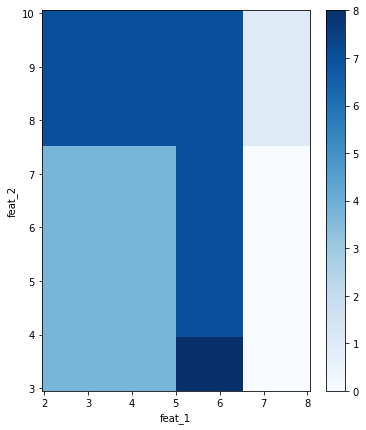

In [70]:
#visualize the decisions
feat1, feat2 = np.meshgrid(np.linspace(2, 8, 60), np.linspace(3, 10, 70))
feat1, feat2 = feat1.flatten(), feat2.flatten()
x = np.stack([feat1, feat2], axis=1)
ypred = model.predict(x)

fig, ax = plt.subplots(figsize=(6, 7))
im = plt.pcolormesh(feat1.reshape(70, 60), feat2.reshape(70, 60), ypred.reshape(70, 60), cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xlabel('feat_1')
ax.set_ylabel('feat_2')
plt.show()

In [72]:
tree_rules = export_text(model, feature_names=list(X.columns))
print(tree_rules)

|--- feature_1 <= 6.50
|   |--- feature_1 <= 5.00
|   |   |--- feature_2 <= 7.50
|   |   |   |--- value: [3.75]
|   |   |--- feature_2 >  7.50
|   |   |   |--- value: [7.00]
|   |--- feature_1 >  5.00
|   |   |--- feature_2 <= 4.00
|   |   |   |--- value: [8.00]
|   |   |--- feature_2 >  4.00
|   |   |   |--- value: [7.00]
|--- feature_1 >  6.50
|   |--- feature_2 <= 7.50
|   |   |--- value: [0.00]
|   |--- feature_2 >  7.50
|   |   |--- feature_1 <= 8.00
|   |   |   |--- value: [1.00]
|   |   |--- feature_1 >  8.00
|   |   |   |--- value: [0.00]



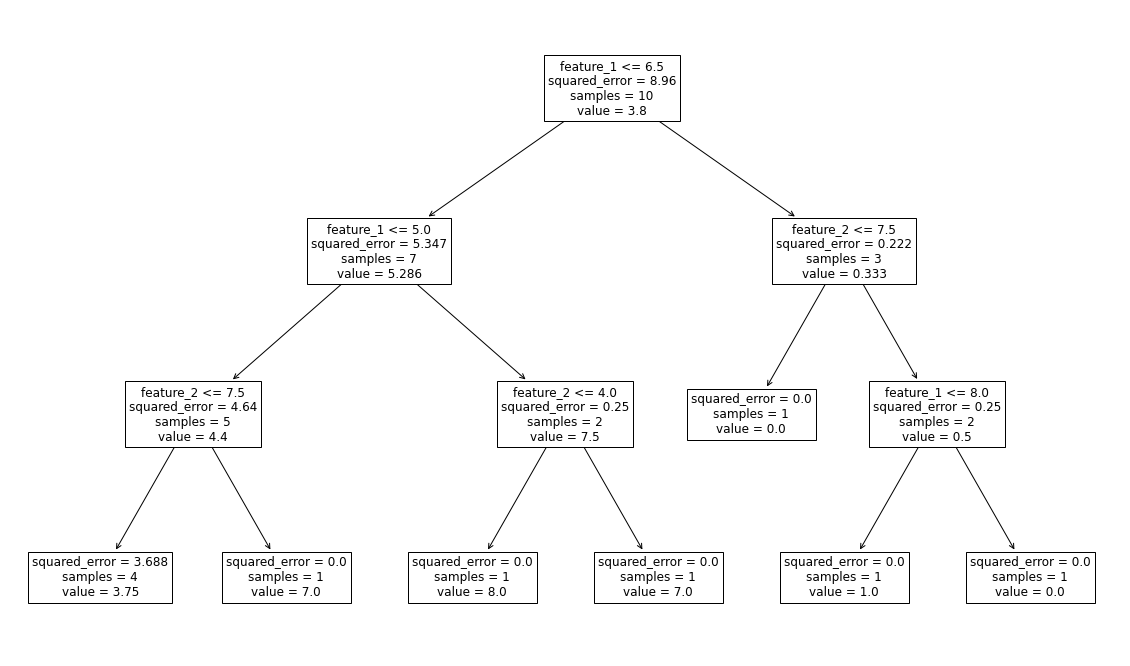

In [73]:
#view the tree to a depth of 3
from sklearn import tree

plt.figure(figsize=(20, 12))
tree.plot_tree(model, max_depth=3, 
               feature_names=X.columns,
               class_names=["blue", "red"],
               fontsize=12)

plt.show()

## Random Forests

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [90]:
model.score(X_val, y_val)

0.933

#### Out-of-Bag Score

In [91]:
model = RandomForestClassifier(oob_score=True)
model.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

In [92]:
model.oob_score_

0.92

#### Feature Importances

See [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html) for in-depth discussion. 

In [93]:
model.feature_importances_

array([0.52713219, 0.47286781])

In [96]:
#!pip install rfpimp

In [104]:
from rfpimp import *

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_val, y_val)

X_val = pd.DataFrame(X_val, columns=['lon', 'lat'])
y_val = pd.DataFrame(y_val, columns=['vote'])

importances(rf, X_val, y_val)

,Importance
Feature,
lon,0.4025
lat,0.3655


In [75]:
#Plots training error and testing error, using various amounts of trees in the random forest.
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier
   
    Parameters
    ----------
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_test: numpy.ndarray        
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set    
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot
            
    """    
    train_err = []
    test_err = []
    for ntree in num_trees:
        model = RandomForestClassifier(n_estimators=ntree)
        model.fit(X_train, y_train)
        train_err.append(1-model.score(X_train, y_train))
        test_err.append(1-model.score(X_test, y_test))

    fig, ax = plt.subplots()
    ax.plot(num_trees,train_err,label="train")
    ax.plot(num_trees,test_err,label="test")
    ax.set_xlabel('number of trees');
    ax.set_ylabel('error rate');
    ax.set_xscale('log')
    ax.legend()
    plt.show()

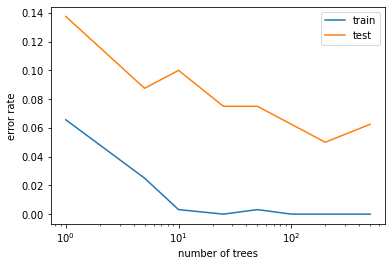

In [76]:
#fit a random forest for various n_estimators and plot the error
make_num_tree_plot(X_train, y_train, X_val, y_val, (1,5,10,25,50,100,200,500))

## Ensembles
### Boosting Example

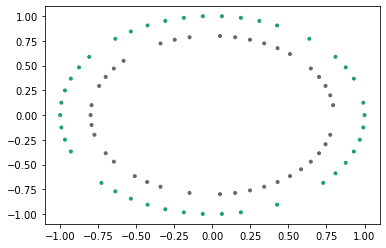

In [77]:
# Let's generate some fake data

# generate blobs with fixed random generator
n = 100
n_classes = 2
X, y = make_circles(n_samples=n, random_state = 122)

X_train_circ, X_test_circ, y_train_circ, y_test_circ = train_test_split(X, y, test_size=0.2)

fig, ax = plt.subplots()
ax.scatter(*X_train_circ.T, c=y_train_circ, marker='.', cmap='Dark2');

In [78]:
from sklearn.ensemble import AdaBoostClassifier

In [79]:
#create the adaboost classifier and fit it
ensemble = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=3)
ensemble.fit(X_train_circ, y_train_circ)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=3)

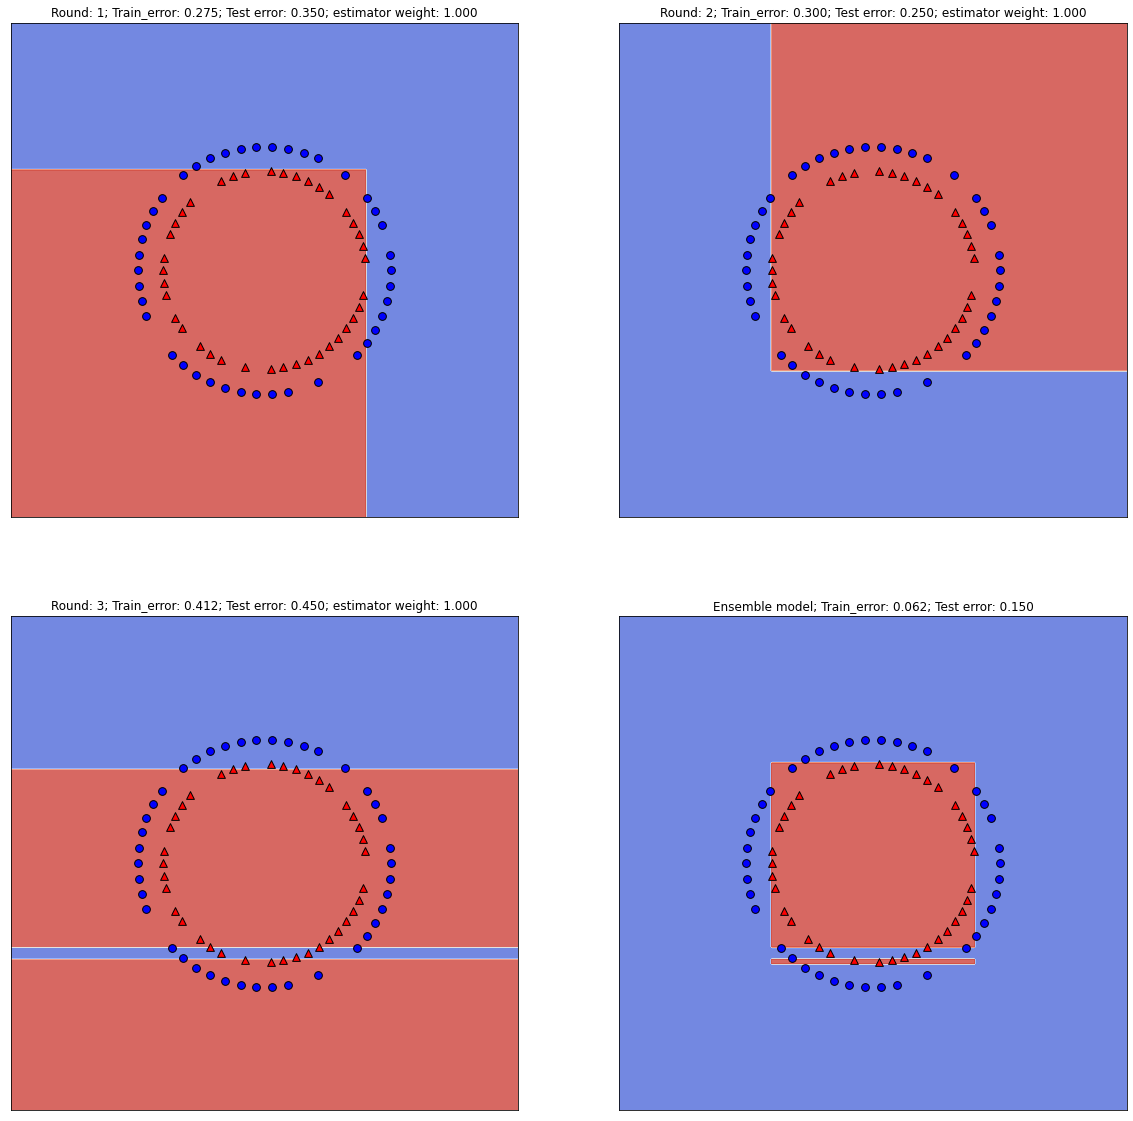

In [80]:
#located in plotclassifier.py (contains plot_classifier function)
from plotclassifier import *

# Combine weak learners 
fig, axs = plt.subplots(2, 2, figsize=(20,20))
weights = ensemble.estimator_weights_
for i, estimator in enumerate(ensemble.estimators_): # needs scikit-learn-0.20
    ax = axs[i//2, i % 2]
    plot_classifier(X_train_circ, y_train_circ, estimator, ax=ax)
    tr_err = (1 - estimator.score(X_train_circ, y_train_circ))
    te_err = (1 - estimator.score(X_test_circ, y_test_circ))
    title = f'Round: {i + 1}; Train_error: {tr_err:0.3f}; Test error: {te_err:0.3f}; estimator weight: {weights[i]:0.3f}'
    ax.set_title(title);
    
ax = axs[1, 1]
plot_classifier(X_train_circ, y_train_circ, ensemble, ax=plt.gca())
tr_err = (1 - ensemble.score(X_train_circ, y_train_circ))
te_err = (1 - ensemble.score(X_test_circ, y_test_circ))
title = f'Ensemble model; Train_error: {tr_err:0.3f}; Test error: {te_err:0.3f}'
ax.set_title(title)

plt.show()

### Stacking example

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier  #meta model

In [83]:
# Load a smaller version of the cities dataset
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data['X']
y_train = data['y']
X_val = data['Xtest']
y_val = data['ytest']

In [84]:
# Create a simple voting classifier using scikit-learn's VotingClassifier

classifiers = {
    "Decision tree"         : DecisionTreeClassifier(max_depth=5),
    "KNN"                   : KNeighborsClassifier(),
    "Naive Bayes"           : GaussianNB(),
    "Logistic Regression"   : LogisticRegression(),
}

# voting="soft" predicts the class label based on the argmax of the sums of the predicted probabilities
ensemble = VotingClassifier(classifiers.items(), voting="soft")

# note: sklearn doesn't seem to support passing pre-trained classifiers into VotingClassifier
ensemble.fit(X_train, np.ravel(y_train))

print('Ensemble performance: \n')
print("Training error:   %.2f" % (1-ensemble.score(X_train, y_train)))
print("Validation error: %.2f" % (1-ensemble.score(X_val, y_val)))

Ensemble performance: 

Training error:   0.05
Validation error: 0.09


In [85]:
## What's the performance of individual classifiers in the ensemble?
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_val, y_val))
    print('%s: Train_error: %0.3f; Validation error: %0.3f'%(name, tr_err, te_err))

Decision tree: Train_error: 0.065; Validation error: 0.123
KNN: Train_error: 0.042; Validation error: 0.069
Naive Bayes: Train_error: 0.338; Validation error: 0.367
Logistic Regression: Train_error: 0.307; Validation error: 0.333


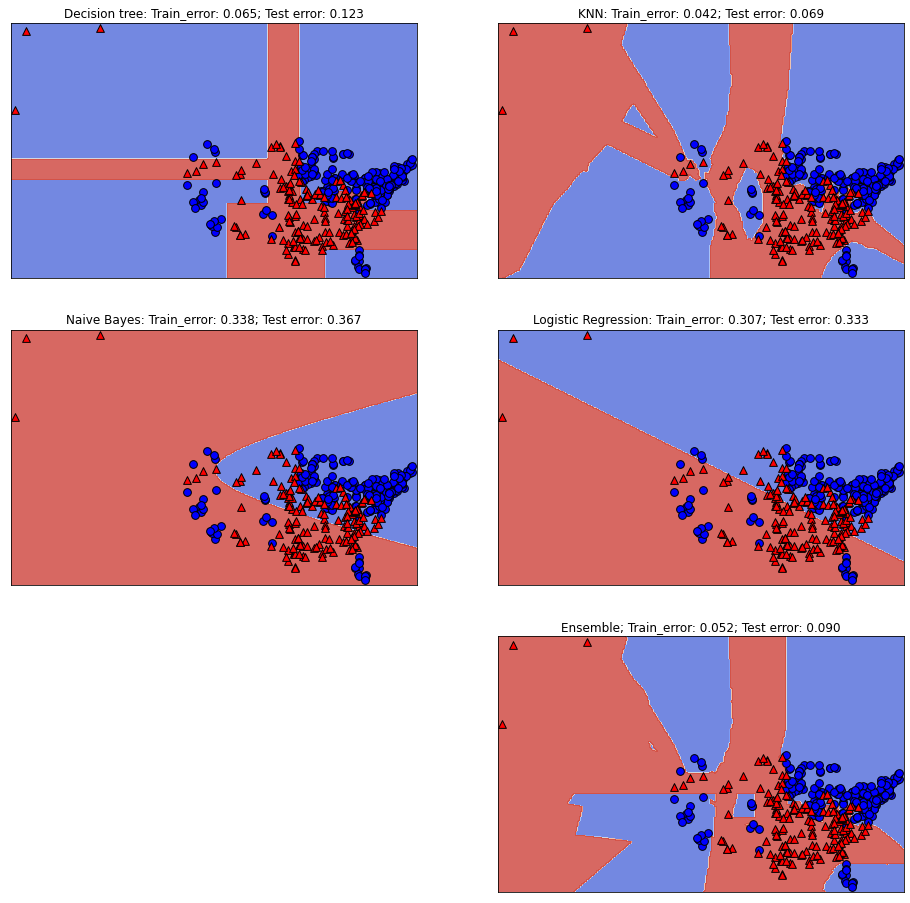

In [86]:
plt.figure(figsize=(16,16))
count = 1
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    plt.subplot(3,2,count)
    plot_classifier(X_train, y_train, estimator, ax=plt.gca());
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_val, y_val))
    title = '%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err)    
    plt.title(title);
    count += 1
    
plt.subplot(3,2,6)
plot_classifier(X_train, y_train, ensemble, ax=plt.gca());
tr_err = 1 - ensemble.score(X_train, y_train)
te_err = 1 - ensemble.score(X_val, y_val)
title = '%s; Train_error: %0.3f; Test error: %0.3f'%('Ensemble', tr_err, te_err)    
plt.title(title);